<a href="https://colab.research.google.com/github/Eshan133/Handwritten_Digit_Recognition-MNIST-/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# 1. Getting the **dataset**

## 1.1 **Loading Dataset** MNIST

In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 29.7MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.50MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.02MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# 1.2 **Data Visualization**

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_name = train_data.classes
class_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
class_id = train_data.class_to_idx
class_id

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [8]:
img, label = train_data[0]

In [9]:
img.shape

torch.Size([1, 28, 28])

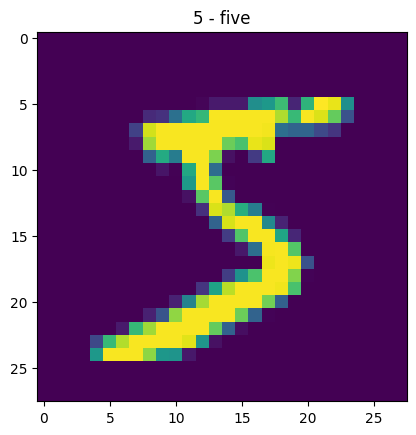

In [10]:
plt.imshow(img.squeeze())
plt.title(class_name[label])
plt.show()

**Needed:**
- `class_name`
- `class_id`

# 2. Preparing **DataLoader**

In [11]:
from torch.utils.data import DataLoader

In [12]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

## 2.1 Visualizing DataLoader

In [13]:
print(f"DataLoaders{train_dataloader, test_dataloader}")
print("-------------------------------------------------")
print(f"Total length of train data: {len(train_data)}")
print(f"Total length of test data: {len(test_data)}")
print("-------------------------------------------------")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")


DataLoaders(<torch.utils.data.dataloader.DataLoader object at 0x7dc0a41bb950>, <torch.utils.data.dataloader.DataLoader object at 0x7dc0a415a050>)
-------------------------------------------------
Total length of train data: 60000
Total length of test data: 10000
-------------------------------------------------
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [14]:
train_features, train_labels = next(iter(train_dataloader))

In [15]:
print(f"Shape of train features in single iteration: {train_features.shape}")
print(f"Shape of train labels in single iteration: {train_labels.shape}")

Shape of train features in single iteration: torch.Size([32, 1, 28, 28])
Shape of train labels in single iteration: torch.Size([32])


## 2.2 Extracting data from the dataloader

Random image shape: torch.Size([1, 28, 28])


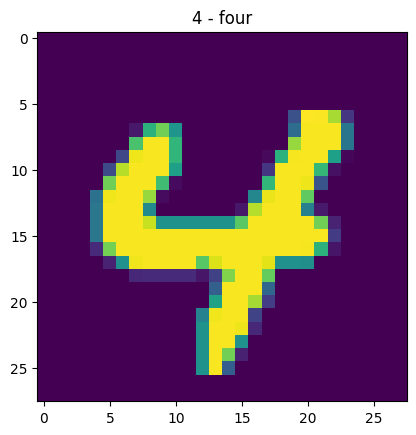

In [16]:
random_idx = torch.randint(0, len(train_features), size=[1]).item()
img = train_features[random_idx]
label = train_labels[random_idx]

print(f"Random image shape: {img.shape}")

plt.imshow(img.squeeze())
plt.title(class_name[label])
plt.show()

----

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 3. Building a **MODEL**

## 3.1 Base Model

In [18]:
class MNISTmodelV1(nn.Module):
  def __init__(self, input_shape:int, hidden_shape:int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape,
              out_features=hidden_shape),
      nn.Linear(in_features=hidden_shape,
              out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [19]:
modelV1 = MNISTmodelV1(input_shape=784,
                       hidden_shape=10,
                       output_shape=len(class_name)).to(device)

In [20]:
modelV1

MNISTmodelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

---

# 4. Train the model

## 4.1 Setting up loss, accuracy and optimizer function

In [21]:
import requests
from pathlib import Path

if(Path("helper_functions.py").is_file()):
  print("helper_functions.py already exists")
else:
  print("Downloading")
  request = requests.get("https://raw.githubusercontent.com/Eshan133/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
    print("Download complete")


Downloading
Download complete


In [22]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.01)

## 4.2 Define Timer function

In [23]:
from timeit import default_timer as timer

def print_time(start:float, end:float, device:torch.device=None):
  total_time = end - start
  print(f"Total time taken on {device}: {total_time:.3f} seconds")
  return total_time

In [24]:
# Timer demo
start_timer = timer()

end_timer = timer()
print_time(start=start_timer, end=end_timer, device=device)

Total time taken on cpu: 0.000 seconds


7.519199999705961e-05

In [25]:
test_dataloader

## 4.3 Training the model

In [26]:
from tqdm.auto import tqdm

start_timer = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")

  # Training Loop
  train_loss = 0
  train_acc = 0

  modelV1.train()
  for batch, (X,y) in enumerate(train_dataloader):

    # Device matching
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = modelV1(X)

    # Loss Calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Accuracy Calculation
    acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_acc += acc

    # Optimizer zero
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"Train Loss: {train_loss}, Train Acc: {train_acc}")

  # Testing loop
  test_loss = 0
  test_acc = 0

  modelV1.eval()
  with torch.inference_mode():
    for(X,y) in test_dataloader:
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = modelV1(X)

      # Loss Calculation
      loss = loss_fn(y_pred, y)
      test_loss += loss

      # Accuracy Calculation
      acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
      test_acc += acc

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")
  print("----------------------------------------------")

end_timer = timer()
print_time(start=start_timer, end=end_timer, device=device)



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.8651232719421387, Train Acc: 77.365
Test Loss: 0.430940181016922, Test Acc: 88.64816293929712
----------------------------------------------
Epoch: 1
Train Loss: 0.39874765276908875, Train Acc: 89.04333333333334
Test Loss: 0.3483341336250305, Test Acc: 90.05591054313099
----------------------------------------------
Epoch: 2
Train Loss: 0.3494911789894104, Train Acc: 90.13
Test Loss: 0.32225584983825684, Test Acc: 90.76477635782747
----------------------------------------------
Total time taken on cpu: 55.809 seconds


55.80906449

---

# 5. Evaluation

## 5.1 Creating Evaluation function (`eval`)

In [27]:
def eval(model:torch.nn.Module,
         dataloader:torch.utils.data.dataloader,
         loss_fn:torch.nn.Module,
         accuracy_fn,
         device:torch.device=device):
  model.eval()

  model.to(device)
  total_loss = 0
  total_acc = 0

  with torch.inference_mode():
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = model(X)

      # Loss
      loss = loss_fn(y_pred, y)
      total_loss += loss

      # Accuracy
      acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
      total_acc += acc

    total_acc /= len(dataloader)
    total_loss /= len(dataloader)

  return {
      'model_name': model.__class__.__name__,
      'model_loss': total_loss.item(),
      'model_accuracy': total_acc
  }

## 5.2 Evaluating the base model

In [28]:
eval_report_1 = eval(model=modelV1, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
eval_report_1

{'model_name': 'MNISTmodelV1',
 'model_loss': 0.3223216235637665,
 'model_accuracy': 90.75479233226837}

----

# 6. Functionizing the training and testing loop

## 6.1 Training Loop

In [29]:
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forwared Pass
    y_pred = model(X)

    # Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Accuracy
    acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_acc += acc

    # Optimizer zero
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss:.5f} || Train Accuracy: {train_acc:.2f}%")

## 6.2 Testing Loop

In [30]:
def test_loop(model,
              dataloader,
              loss_fn,
              accuracy_fn,
              device):

  model.eval()
  model.to(device)

  with torch.inference_mode():
    test_acc, test_loss = 0, 0
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
      test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  print(f"Test Loss: {test_loss:.5f} || Train Accuracy: {test_acc:.2f}%")



In [31]:
epochs = 3
start_time = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_loop(model= modelV1,
             dataloader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)

  test_loop(model= modelV1,
             dataloader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

end_time = timer()
print_time(start_time, end_time, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.32704 || Train Accuracy: 90.69%
Test Loss: 0.31675 || Train Accuracy: 91.05%
Epoch: 1
Train Loss: 0.31324 || Train Accuracy: 91.05%
Test Loss: 0.30608 || Train Accuracy: 91.33%
Epoch: 2
Train Loss: 0.30372 || Train Accuracy: 91.44%
Test Loss: 0.29871 || Train Accuracy: 91.51%
Total time taken on cpu: 53.708 seconds


53.70783145400003

---
# 7. Building a CNN **(Tiney VGG Net)**

In [37]:
class MNISTmodelV2(nn.Module):
  def __init__(self,
               input_shape,
               hidden_shape,
               output_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
        out_channels=hidden_shape,
        kernel_size=3,
        stride=1,
        padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_shape,
        out_channels=hidden_shape,
        kernel_size=3,
        stride=1,
        padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_shape,
        out_channels=hidden_shape,
        kernel_size=3,
        stride=1,
        padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_shape,
        out_channels=hidden_shape,
        kernel_size=3,
        stride=1,
        padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_shape*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print("After 1st block: ",x.shape)

    x = self.conv_block_2(x)
    # print("After 2nd block: ",x.shape)

    x = self.classifier(x)
    # print("After Classifier block: ",x.shape)

    return x


In [38]:
modelV2 = MNISTmodelV2(input_shape=1,
                       hidden_shape=10,
                       output_shape=len(class_name)).to(device)

In [39]:
train_dataloader.dataset.data[1].shape

torch.Size([28, 28])

## 7.1 Checking shape to define `in_feature` for **classifier** block

In [40]:
demo_data = torch.randn(1,28,28)

In [41]:
y_pred_demo = modelV2(demo_data)
# Using the reults of conv_block_2: [10, 7, 7], we set the in feature of classifier

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x49 and 490x10)

## 7.2 Defining Loss, Optimizer and Accuracy

In [42]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV2.parameters(), lr=0.1)

## 7.3 Training the model

In [43]:
epochs = 3
start_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_loop(model= modelV2,
             dataloader= train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)

  test_loop(model= modelV2,
             dataloader= train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

end_time = timer()
print_time(start_time, end_time, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.29894 || Train Accuracy: 89.94%
Test Loss: 0.07764 || Train Accuracy: 97.59%
Epoch: 1
Train Loss: 0.07397 || Train Accuracy: 97.72%
Test Loss: 0.06124 || Train Accuracy: 98.17%
Epoch: 2
Train Loss: 0.05655 || Train Accuracy: 98.21%
Test Loss: 0.05630 || Train Accuracy: 98.23%
Total time taken on cpu: 273.660 seconds


273.65957954900006

## 7.4 Evaluating the model

In [ ]:
eval_report_2 = eval(model=modelV2,
                     dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     device=device)

## 8. Comparing for the best model

In [ ]:
import pandas as pd

compare_model = pd.DataFrame([
    eval_report_1,
    eval_report_2
])

In [ ]:
compare_model

In [ ]:
compare_model.set_index("model_name")["model_accuracy"].plot(kind='barh')
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

# 8. Making prediction with the best model `MNISTmodelV1`

In [51]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device=device):

  pred_probs = []
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [52]:
# Creating list that can store 9 samples (for visualization)

import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [55]:
# Making prediction
pred_probs = make_predictions(model=modelV2, data=test_samples)
pred_probs

tensor([[7.6968e-04, 2.6675e-03, 3.1666e-05, 9.2428e-07, 1.2683e-04, 1.6424e-04,
         9.9623e-01, 4.8026e-07, 7.1315e-06, 1.0832e-07],
        [5.9993e-08, 1.2534e-07, 7.3489e-03, 9.5195e-01, 1.1823e-07, 1.9134e-03,
         1.3728e-08, 3.6036e-02, 4.9098e-05, 2.6996e-03],
        [1.6849e-05, 9.9749e-01, 2.0953e-04, 1.8099e-06, 4.6129e-04, 3.5114e-05,
         1.0569e-05, 5.4736e-05, 1.6829e-03, 4.0292e-05],
        [1.0057e-10, 7.5962e-08, 2.2851e-07, 4.2969e-05, 1.7354e-08, 7.6656e-08,
         1.6278e-14, 9.9947e-01, 3.0903e-07, 4.8646e-04],
        [9.9998e-01, 3.5438e-10, 8.4524e-06, 6.5372e-09, 1.2802e-09, 6.8297e-10,
         9.4720e-07, 4.5920e-09, 2.6737e-08, 7.8115e-06],
        [3.9414e-10, 5.5428e-07, 2.2858e-06, 1.8741e-10, 1.0000e+00, 1.8475e-09,
         4.5474e-09, 3.4988e-11, 3.5959e-08, 3.0063e-09],
        [2.3233e-06, 3.6442e-05, 1.3110e-05, 6.5068e-08, 9.9995e-01, 2.2560e-09,
         1.3670e-06, 1.6492e-07, 8.3413e-09, 7.8347e-09],
        [2.0344e-05, 2.5240

In [54]:
# Defining prediction class
pred_class = pred_probs.argmax(dim=1)
pred_class

tensor([6, 3, 1, 7, 0, 4, 4, 2, 4])

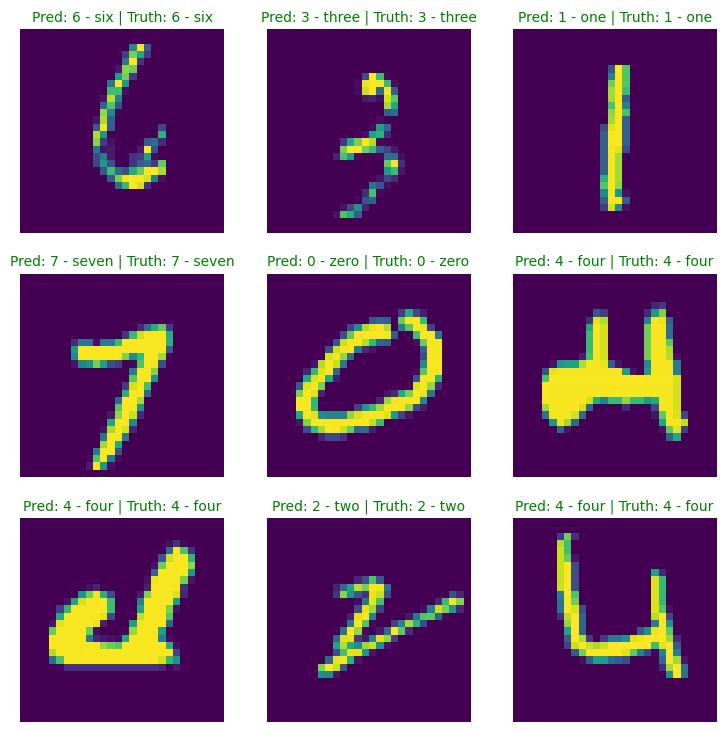

In [57]:
plt.figure(figsize=(9,9))

nrow = 3
ncol = 3

for i, sample in enumerate(test_samples):

  plt.subplot(nrow, ncol, i+1)

  plt.imshow(sample.squeeze())

  # Preparing the title for displaying the output
  pred_label = class_name[pred_class[i]]
  truth_label = class_name[test_labels[i]]

  title = f"Pred: {pred_label} | Truth: {truth_label}"

  if(pred_label == truth_label):
    plt.title(title, fontsize=10, c='g')
  else:
    plt.title(title, fontsize=10, c='r')

  plt.axis(False)

---

# 9. Evaluation using **Confusion Matrix**

In [59]:
# Prediction for all the test_data.

from tqdm.auto import tqdm

y_preds = []
modelV2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc = "Making Predictions..."):
    X, y = X.to(device), y.to(device)

    y_logit =modelV2(X)

    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    y_preds.append(y_pred.cpu())

  # print(y_preds)
  y_pred_tensor = torch.cat(y_preds)
  y_pred_tensor

Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

## 9.1 Installing Packages **(Right way to do it)**

In [60]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00
mlxtend version: 0.23.4


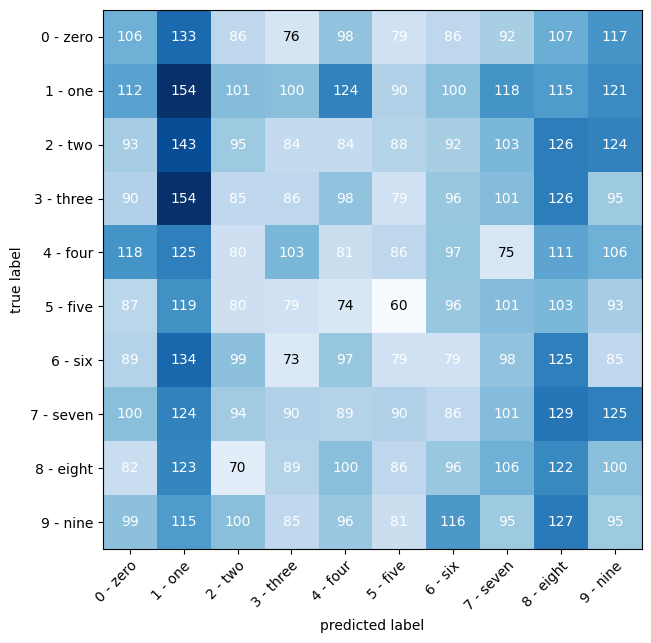

In [61]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    figsize=(10,7),
    class_names=class_name,
    # show_normed=True
)